# Modeling

- [Thresholding](#chapter1)
- [Logistic Regression](#chapter2)
- [K-Nearest Neighbors](#chapter3)
- [Random Forest Classifier](#chapter4)
    - [Misclassification Analysis](#chapter4.1)
- [Summary](#chapter5)

I'm going to test out a few different models. The most important thing to look for is the recall of each model, since I want to minimize false negative predictions. In the real world, if there is a tornado warning but no tornado, nothing too devastating will happen. However, if there's no warning and a tornado occurs, the consequences could be life-threatening.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, recall_score, \
                            precision_score, f1_score, precision_recall_curve, fbeta_score, \
                            plot_precision_recall_curve

import warnings 
warnings.filterwarnings('ignore')

First let's read in the data files.

In [2]:
tornado = pd.read_csv('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/tornado_modeling.csv')

In [3]:
tornado_target = pd.read_csv('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/tornado_downsized.csv')

In [4]:
tornado.head()

,LATITUDE,LONGITUDE,ELEVATION,DEWP,GUST,MAX,MIN,MXSPD,PRCP,SLP,STP,TEMP,VISIB,WDSP,APRIL,JULY
0,-0.850279,0.492887,-0.995130,0.301508,0.348315,-0.181287,0.265766,0.163934,0.045977,-0.316667,0.672365,0.103542,-5.166667,1.400,0,0
1,0.000895,-0.661856,0.607143,0.346734,-0.325843,0.228070,0.495495,-0.327869,0.000000,0.200000,-0.239316,0.386921,-0.750000,0.325,0,0
2,-0.873778,0.117740,-0.876623,0.844221,-0.112360,1.000000,0.851351,0.311475,0.000000,-0.766667,0.284900,0.866485,-1.500000,-0.850,0,0
3,0.597711,0.548893,0.000000,0.321608,0.112360,-0.087719,0.306306,0.311475,7.356322,0.150000,0.125356,0.130790,-0.166667,-0.275,0,0
4,0.875913,0.329284,0.701299,0.251256,0.213483,0.409357,0.306306,-0.163934,4.827586,-0.200000,-0.649573,0.245232,-0.583333,-0.200,0,0


I found that the most relevant features were GUST and SLP while testing feature importance. Other non-colinear features that were less important but still significant to some degree were LATITUDE, ELEVATION, VISIB, WDSP, APRIL, and JULY. These will be the features that I use during the modeling process.

In [5]:
# list of relevant columns
features = ['LATITUDE', 'ELEVATION', 'GUST', 'SLP', 'VISIB', 'WDSP', 'APRIL', 'JULY']

In [6]:
# create X and y variables
X = tornado[features]
y = tornado_target['TORNADO']

In [7]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=45)

Since there was a fair amount of missing data, there were too few tornado events to use a 0.8/0.2 train/test split so I decided to use a .5/.5 split. This will increase variance but will hopefully reduce overfitting.

# Thresholding <a class="anchor" id="chapter1"></a>

The function below returns the best threshold for y_pred. I have decided that the optimal threshold is one that has a precision as close to 0.5 as possible. The model with the best corresponding recall will be the best model.

In [8]:
# define threshold function
def threshold(model, X_test, y_test):
    
    # create list of thresholds to test
    thresh_dict = {}
    nums = list(range(1,100))
    thresh_list = [l*0.01 for l in nums]
    
    # loop through thresh_list to get y_pred, then precision score
    for e in thresh_list:
        y_pred = np.where(model.predict_proba(X_test)[:,1] > e, 1, 0)
        score_precision = precision_score(y_test, y_pred)
        
        # assign all scores > 0.5 to dictionary with threshold as key
        if score_precision > 0.5:
            thresh_dict[e] = score_precision - 0.5
        
    # return threshold value corresponding to precision closest to 0.5
    return min(thresh_dict, key=thresh_dict.get)

# Logistic Regression <a class="anchor" id="chapter2"></a>

The first model I want to test is Logistic Regression. I need to first find the optimal C value by using GrisSearchCV

In [9]:
# set up param_grid with various C values
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# instantiate, perform cross-validation, and fit model
logreg = LogisticRegression(max_iter=1000)
logreg_cv = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5)
logreg_cv.fit(X_train, y_train)
y_pred = logreg_cv.predict(X_test)

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best Score: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best Score: 0.8996227496846692


In [10]:
# instantiate, fit, and predict logreg model with optimal C parameter, threshold
logreg = LogisticRegression(C=10**0.439397, max_iter=1000)
logreg.fit(X_train, y_train)
thresh = threshold(logreg, X_test, y_test)
y_pred = np.where(logreg.predict_proba(X_test)[:,1] > thresh, 1, 0)
logreg_recall = recall_score(y_test, y_pred)

# use cross_val_score with scoring='roc_auc'
logreg_cv_score = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')
print(logreg_cv_score)
print("Mean AUC Score: ", logreg_cv_score.mean())
print(thresh)

[0.90962963 0.83777778 0.90814815 0.89851852 0.93962848]
Mean AUC Score:  0.8987405114092419
0.17


In [11]:
# print classification report
print('Classification Report')
print('-----------------------------------------------------')
print(classification_report(y_test, y_pred))

Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       368
           1       0.51      0.86      0.64        97

    accuracy                           0.80       465
   macro avg       0.73      0.82      0.75       465
weighted avg       0.86      0.80      0.81       465



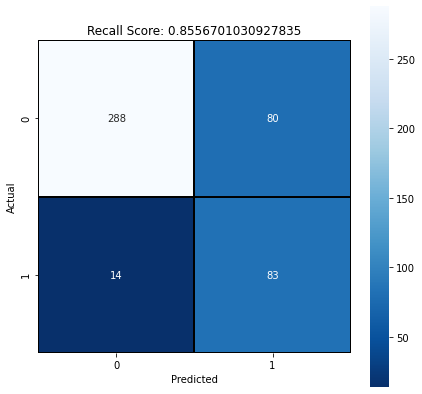

In [12]:
# plot confusion matrix in seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='.0f', linewidth=1, linecolor='black', square = True, cmap = 'Blues_r');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Recall Score: {0}'.format(logreg_recall)
plt.title(all_sample_title);

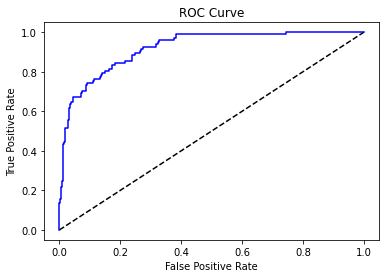

ROC_AUC:  0.9198229493500673


In [13]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('ROC_AUC: ', roc_auc)

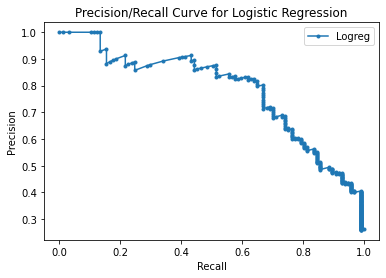

In [14]:
# plot precision/recall curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.', label='Logreg')
plt.title('Precision/Recall Curve for Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [15]:
# calculate f-beta score
fbeta = fbeta_score(y_test, y_pred, average='weighted', beta=2)
fbeta

0.7995114948579003

In [16]:
# bootstrapping

n_iters = 100
recall = []
precision = []

for i in range(n_iters):
    
    # split data into training and test set, instantiate RFC model
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size=0.5, random_state=i)
    logreg_cv = LogisticRegression(max_iter=1000)
    logreg_cv = GridSearchCV(logreg_cv, param_grid, scoring='roc_auc', cv=5)
    logreg_cv.fit(X_train, y_train)
    model = LogisticRegression(**logreg_cv.best_params_)
    
    # fit and predict
    model.fit(X_train_b, y_train_b)
    thresh_b = threshold(model, X_test_b, y_test_b)
    y_pred_b = np.where(model.predict_proba(X_test_b)[:,1] > thresh_b, 1, 0)
    
    # calculate precision, recall
    score_recall = recall_score(y_test_b, y_pred_b)
    score_precision = precision_score(y_test_b, y_pred_b)
    
    # append scores to lists
    recall.append(score_recall)
    precision.append(score_precision)

In [17]:
# get confidence intervals for precision and recall

alpha = 0.95
p_low = 2.5
p_high = 97.5

lower_recall = max(0.0, np.percentile(recall, 2.5))
upper_recall = min(1.0, np.percentile(recall, 97.5))
lower_precision = max(0.0, np.percentile(precision, 2.5))
upper_precision = min(1.0, np.percentile(precision, 97.5))

print('%.1f confidence interval Recall: %.1f%% and %.1f%%' % (95, lower_recall*100, upper_recall*100))
print('%.1f confidence interval Precision: %.1f%% and %.1f%%' % (95, lower_precision*100, upper_precision*100))

95.0 confidence interval Recall: 70.2% and 93.4%
95.0 confidence interval Precision: 50.3% and 52.2%


# K-Nearest Neighbors <a class="anchor" id="chapter3"></a>

The next model I want to use is K_Nearest Neighbors. I first need to use cross-validation to find the optimal number of neighbors.

In [18]:
# use GridSearchCV to find best value of C
knn_cv = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn_cv, param_grid, scoring='roc_auc', cv=5)
knn_gscv.fit(X_train, y_train)
n_neighbors = knn_gscv.best_index_ + 1

print('n_neighbors: ', n_neighbors)
print(knn_gscv.best_score_)

n_neighbors:  22
0.8904892787524366


In [19]:
# instantiate final KNN classifier, with optimal n_neighbors value
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)
thresh = threshold(knn, X_test, y_test)
y_pred = np.where(knn.predict_proba(X_test)[:,1] > thresh, 1, 0)
knn_recall = recall_score(y_test, y_pred)

# use cross_val_score with scoring='roc_auc', to check variability
knn_cv_score = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc')
print(knn_cv_score)
print("Mean AUC Score: ", knn_cv_score.mean())
print(thresh)

[0.91444444 0.81814815 0.92296296 0.86925926 0.92763158]
Mean AUC Score:  0.8904892787524366
0.19


In [20]:
# print classification report
print('Classification Report')
print('-----------------------------------------------------')
print(classification_report(y_test, y_pred))

Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       368
           1       0.52      0.88      0.66        97

    accuracy                           0.81       465
   macro avg       0.74      0.83      0.76       465
weighted avg       0.87      0.81      0.82       465



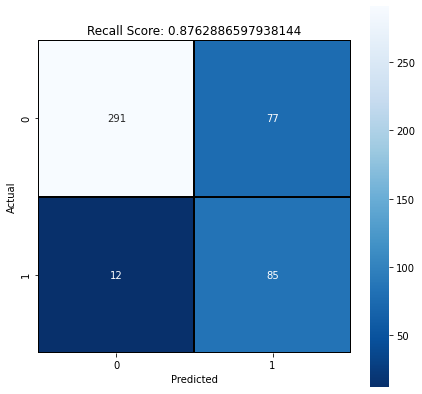

In [21]:
# plot confusion matrix in seaborn heatmap
cm_knn = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm_knn, annot=True, fmt='.0f', linewidth=1, linecolor='black', square = True, cmap = 'Blues_r');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Recall Score: {0}'.format(knn_recall)
plt.title(all_sample_title);

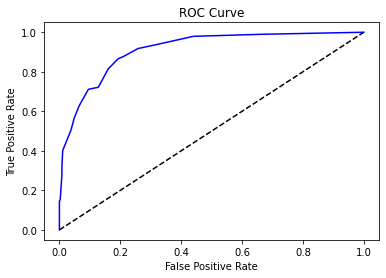

ROC_AUC:  0.9115727252353205


In [22]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('ROC_AUC: ', roc_auc)

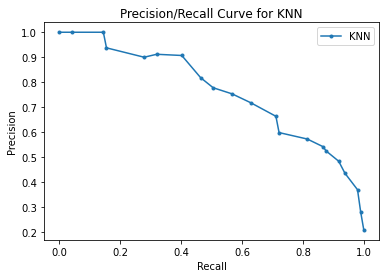

In [23]:
# plot precision/recall curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.', label='KNN')
plt.title('Precision/Recall Curve for KNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [24]:
# calculate f_beta score
fbeta = fbeta_score(y_test, y_pred, average='weighted', beta=2)
fbeta

0.8099158784574504

In [25]:
# bootstrapping

n_iters = 100
recall = []
precision = []

for i in range(n_iters):
    
    # split data into training and test set, instantiate RFC model
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size=0.5, random_state=i)
    knn_cv = KNeighborsClassifier()
    param_grid = {'n_neighbors': np.arange(1, 25)}
    knn_gscv = GridSearchCV(knn_cv, param_grid, scoring='roc_auc', cv=5)
    knn_gscv.fit(X_train, y_train)
    n_neighbors = knn_gscv.best_index_ + 1
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # fit and predict
    model.fit(X_train_b, y_train_b)
    thresh_b = threshold(model, X_test_b, y_test_b)
    y_pred_b = np.where(model.predict_proba(X_test_b)[:,1] > thresh_b, 1, 0)
    
    # calculate precision, recall
    score_recall = recall_score(y_test_b, y_pred_b)
    score_precision = precision_score(y_test_b, y_pred_b)
    
    # append scores to lists
    recall.append(score_recall)
    precision.append(score_precision)

In [26]:
# get confidence intervals for precision and recall

alpha = 0.95
p_low = 2.5 
p_high = 97.5 

lower_recall = max(0.0, np.percentile(recall, 2.5))
upper_recall = min(1.0, np.percentile(recall, 97.5))
lower_precision = max(0.0, np.percentile(precision, 2.5))
upper_precision = min(1.0, np.percentile(precision, 97.5))

print('%.1f confidence interval Recall: %.1f%% and %.1f%%' % (95, lower_recall*100, upper_recall*100))
print('%.1f confidence interval Precision: %.1f%% and %.1f%%' % (95, lower_precision*100, upper_precision*100))

95.0 confidence interval Recall: 69.8% and 90.8%
95.0 confidence interval Precision: 50.3% and 55.9%


# Random Forest <a class="anchor" id="chapter4"></a>

Need to do GridSearchCV on RF Classifier like above 2 models

In [27]:
# instantiate RFC model, set up param_grid
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [3,4,5,6,7,8],
    'criterion': ['gini', 'entropy']
}

# GridSearch to find best parameters 
rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='roc_auc', cv=5)
rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500]},
             scoring='roc_auc')

In [28]:
rfc_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 100}

In [29]:
# instantiate another RFC with optimal parameters, fit, predict, and calculate recall
rfc_best = RandomForestClassifier(random_state=42, max_features='auto', n_estimators=100, max_depth=6, criterion='entropy')
rfc_best.fit(X_train, y_train)
thresh = threshold(rfc_best, X_test, y_test)
y_pred = np.where(rfc_best.predict_proba(X_test)[:,1] > thresh, 1, 0)
rfc_recall = recall_score(y_test, y_pred)

# use cross_val_score with scoring='roc_auc', to check variability
rfc_cv_score = cross_val_score(rfc_best, X_train, y_train, cv=5, scoring='roc_auc')
print(rfc_cv_score)
print("Mean AUC Score: ", rfc_cv_score.mean())
print(thresh)

[0.93407407 0.85037037 0.94074074 0.90518519 0.95123839]
Mean AUC Score:  0.91632175209265
0.18


In [30]:
# print classification report
print('Classification Report')
print('-----------------------------------------------------')
print(classification_report(y_test, y_pred))

Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       368
           1       0.50      0.95      0.66        97

    accuracy                           0.79       465
   macro avg       0.74      0.85      0.75       465
weighted avg       0.88      0.79      0.81       465



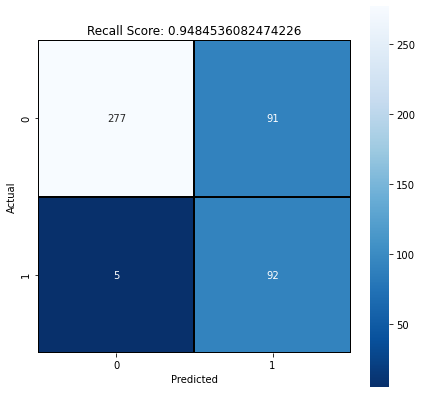

In [31]:
# plot confusion matrix in seaborn heatmap
cm_rfc = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm_rfc, annot=True, fmt='.0f', linewidth=1, linecolor='black', square = True, cmap = 'Blues_r');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Recall Score: {0}'.format(rfc_recall)
plt.title(all_sample_title);

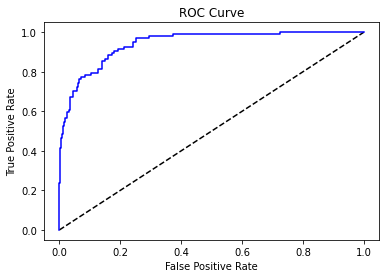

ROC_AUC:  0.9412539220080682


In [32]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = rfc_best.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('ROC_AUC: ', roc_auc)

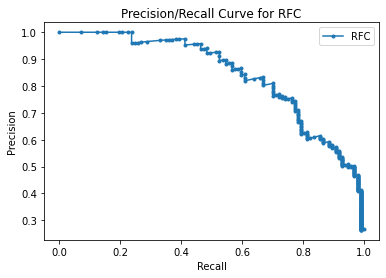

In [33]:
# plot precision/recall curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.', label='RFC')
plt.title('Precision/Recall Curve for RFC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [34]:
# calculate f-beta score
fbeta = fbeta_score(y_test, y_pred, average='weighted', beta=2)
fbeta

0.7929572809503771

In [35]:
# bootstrapping

n_iters = 10
recall = []
precision = []

for i in range(n_iters):
    
    # split data into training and test set, instantiate RFC model
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size=0.5)
    model = RandomForestClassifier(random_state=i, max_features='auto', n_estimators=100, \
                                   max_depth=6, criterion='entropy')
    # fit and predict
    model.fit(X_train_b, y_train_b)
    thresh_b = threshold(model, X_test_b, y_test_b)
    y_pred_b = np.where(model.predict_proba(X_test_b)[:,1] > thresh_b, 1, 0)
    
    # calculate precision, recall
    score_recall = recall_score(y_test_b, y_pred_b)
    score_precision = precision_score(y_test_b, y_pred_b)
    
    # append scores to lists
    recall.append(score_recall)
    precision.append(score_precision)

In [36]:
# get confidence intervals for precision and recall

alpha = 0.95
p_low = 2.5
p_high = 97.5

lower_recall = max(0.0, np.percentile(recall, 2.5))
upper_recall = min(1.0, np.percentile(recall, 97.5))
lower_precision = max(0.0, np.percentile(precision, 2.5))
upper_precision = min(1.0, np.percentile(precision, 97.5))

print('%.1f confidence interval Recall: %.1f%% and %.1f%%' % (95, lower_recall*100, upper_recall*100))
print('%.1f confidence interval Precision: %.1f%% and %.1f%%' % (95, lower_precision*100, upper_precision*100))

95.0 confidence interval Recall: 80.9% and 91.2%
95.0 confidence interval Precision: 50.4% and 52.7%


Source for confidence intervals: https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/

## Misclassification Analysis <a class="anchor" id="chapter4.1"></a>

Now let's look at the 5 events where a tornado occurred but none was predicted.

In [37]:
# add y_pred, y_pred_prob, tornado to X_test and look at misclassifications
X_test['Y_PRED'] = y_pred
X_test['Y_PRED_PROB'] = y_pred_prob
X_test['TORNADO'] = y_test
X_test.loc[(X_test['TORNADO'] == 1) & (X_test['Y_PRED'] == 0)]

,LATITUDE,ELEVATION,GUST,SLP,VISIB,WDSP,APRIL,JULY,Y_PRED,Y_PRED_PROB,TORNADO
745,-0.523503,0.959416,0.000000,0.066667,-0.416667,0.025,0,0,0,0.141597,1
791,0.000000,0.370130,0.112360,0.316667,-1.000000,0.000,0,0,0,0.177877,1
747,-0.523503,0.959416,-0.224719,0.300000,-2.666667,-0.700,0,0,0,0.092251,1
812,0.521595,-0.451299,-0.674157,0.350000,-1.750000,-0.800,1,0,0,0.023619,1
776,0.527866,-0.426948,0.112360,-0.200000,0.166667,0.800,0,0,0,0.175056,1


In [38]:
# look at unscaled weather data of rows where false negatives occurred
tornado = pd.read_csv('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/tornado_downsized.csv')
tornado.iloc[[745, 747, 776, 791, 812]]

,LATITUDE,LONGITUDE,ELEVATION,DEWP,GUST,MAX,MIN,MXSPD,PRCP,SLP,STP,TEMP,VISIB,WDSP,TORNADO,APRIL,JULY
745,31.1827,-90.47080,125.9,53.0,21.0,75.9,48.0,15.0,0.00,1016.4,1.0,59.2,9.1,6.4,1,0,0
747,31.1827,-90.47080,125.9,65.4,19.0,70.0,63.0,13.0,0.08,1017.8,2.4,66.5,6.4,3.5,1,0,0
776,33.4963,-90.08660,40.5,62.6,22.0,73.0,64.0,15.0,0.00,1014.8,10.1,68.2,9.8,9.5,1,0,0
791,32.3347,-88.74420,89.6,48.7,22.0,63.0,34.0,15.0,0.00,1017.9,6.5,54.2,8.4,6.3,1,0,0
812,33.4825,-90.98528,39.0,64.6,15.0,80.1,62.1,8.9,0.04,1018.1,12.8,68.6,7.5,3.1,1,1,0


In [39]:
# look at means of features grouped by TORNADO
tornado.groupby(by='TORNADO').mean()

,LATITUDE,LONGITUDE,ELEVATION,DEWP,GUST,MAX,MIN,MXSPD,PRCP,SLP,STP,TEMP,VISIB,WDSP,APRIL,JULY
TORNADO,,,,,,,,,,,,,,,,
0,32.295222,-89.459360,66.684677,55.595833,21.370296,77.179435,55.887366,14.289247,0.209624,1017.789382,9.670968,65.549731,9.296640,6.236828,0.102151,0.064516
1,32.029929,-89.472517,52.182796,63.112366,31.193011,77.460215,60.937634,20.922043,0.510753,1011.702151,5.337634,68.674731,8.514516,9.193011,0.322581,0.005376


In [40]:
# compared to summary statistics
tornado.describe()

,LATITUDE,LONGITUDE,ELEVATION,DEWP,GUST,MAX,MIN,MXSPD,PRCP,SLP,STP,TEMP,VISIB,WDSP,TORNADO,APRIL,JULY
count,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,32.242163,-89.461991,63.784301,57.099140,23.334839,77.235591,56.897419,15.615806,0.269849,1016.571935,8.804301,66.174731,9.140215,6.828065,0.200000,0.146237,0.052688
std,1.202079,0.846102,36.070360,14.784339,7.845519,13.151298,14.332322,5.435897,0.675066,5.234392,6.007048,13.122704,1.156484,3.093867,0.400215,0.353533,0.223530
min,30.411900,-91.283330,5.500000,0.900000,12.000000,28.000000,10.000000,6.000000,0.000000,1002.100000,0.000000,20.500000,1.100000,0.900000,0.000000,0.000000,0.000000
25%,31.281940,-90.086600,39.000000,48.800000,18.100000,70.000000,46.900000,12.000000,0.000000,1013.400000,4.025000,58.225000,8.800000,4.600000,0.000000,0.000000,0.000000
50%,32.334700,-89.253060,66.800000,61.200000,21.000000,79.000000,60.100000,14.000000,0.000000,1016.000000,7.800000,68.500000,9.600000,6.300000,0.000000,0.000000,0.000000
75%,33.482500,-88.623548,100.600000,68.700000,27.000000,87.100000,69.100000,18.100000,0.217500,1019.400000,12.800000,76.575000,10.000000,8.600000,0.000000,0.000000,0.000000
max,34.262200,-88.450000,125.900000,78.600000,62.000000,102.000000,80.100000,39.000000,7.190000,1040.200000,34.000000,88.000000,10.000000,21.200000,1.000000,1.000000,1.000000


In [41]:
X_test.drop(['Y_PRED', 'Y_PRED_PROB', 'TORNADO'], axis=1, inplace=True)

# Summary <a class="anchor" id="chapter2.3"></a>

After adjusting the features and tuning hyper-parameters, I've come to the decision that the best model is a Random Forest Classifier. I settled on a feature set containing 8 features, LATITUDE, ELEVATION, GUST, SLP, VISIB, WDSP, APRIL, and JULY. This felt like the right amount of features being that it holds the line well of not being too complicated yet still simple enough. 

Looking at the results of the models, I decided to settle on a precision of 0.5 (or as close as possible), and see which model had the best corresponding recall. Logistic Regression and K-Nearest Neighbors yielded recall scores of 0.86 and 0.88 respectively, while the RFC had a recall of 0.95. This difference in performance was evident throughout the entire hyper-parameter tuning process so I'm confident in this model being the most appropriate for the problem at hand

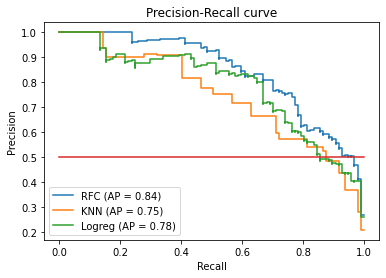

In [42]:
# plot precision-recall curves for each model in single graph
plot_precision_recall_curve(rfc_best, X_test, y_test, ax = plt.gca(),name = "RFC")
plot_precision_recall_curve(knn, X_test, y_test, ax = plt.gca(),name = "KNN")
plot_precision_recall_curve(logreg, X_test, y_test, ax = plt.gca(),name = "Logreg")

# plot line at 0.5 to visualize decision threshold
x = [0,1]
y = [0.5,0.5]
plt.plot(x, y)

# label and show
plt.title('Precision-Recall curve')
plt.show()

Even though 0.95 is still not perfect for recall, I think it was a good result given the feature set and their relatively low correlation to the target. Even though 0.05% of tornadoes will go undetected, this is a good start, and different features might lead to more accurate results in the future. If anything, I have shown the difficulty in being certain about a tornado event occuring on a given day.